# MRS pipeline tutorial

### by Patrick Kavanagh (DIAS, Ireland) August 19th 2017

This notebook demonstrates the execution of the level 2A and 2B pipelines for MRS data in Python using the jwst step classes.

Documentation on each pipeline step can be found here:

http://ssb.stsci.edu/doc/jwst_dev/

The pipeline steps are:

2A: dq_init, saturation, linearity, RSCD, lastframe, dark_current, refpix, jump, ramp_fitting

2B: assign_wcs, bkg_subtract (associations only), flat_field, srctype, straylight, fringe, photom, cube_build, extract_1d

3: mrs_imatch, outlier_detection, cube_build, extract_1d

The file used in this notebook is a MIRISim simulation of a point source with a blackbody spectrum plus emission lines. Note that we will only process the first dither in the MRS_demo_data containing four dither positions.

In this notebook we will pass the step output to subsequent step input in datamodel form. The output from each step is also writting to a fits file.

#### imports

In [1]:
import os, glob, shutil
from subprocess import call

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file, output directory for step outputs:

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'MRS_demo_data'
input_dir = 'MRS_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the output directory name
output_dir = input_dir + '_steps_output'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input file. 
Note that ground test data and MIRISim data will differ here. We can distinguish between the two using the 'ORIGIN' header keyword. Converted ground test data will always have 'STScI' as the origin.

Also note that there is currently a problem running MIRISim data step-wise through the pipeline. One must remove some of the extensions. This has been taken care of in the following cell. This issue has been reported to STScI and this notebook will be updated when it is resolved.

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print "ID\t\t\t\t Detector\t nInts\t nGrps\t rdPatt\t subAr\t chan.\t band"
        print "--------------------------------------------------------------------------------------------------"
        print "%s\t %s\t %d\t %s\t %s\t %s\t %s\t %s" % (identifier,detector,nInts,nGroups,readPatt,subArr,channel,band)
        print "\n\n"
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print "ID\t Detector\t nInts\t nGrps\t rdPatt\t chan.\t band"
        print "--------------------------------------------------------------------------------------------------"
        print "MIRISim\t %s\t %d\t %s\t %s\t %s\t %s" % (detector,nInts,nGroups,readPatt,channel,band)
        print "\n\n"

    # fits extension table
    hdulist.info()

ID	 Detector	 nInts	 nGrps	 rdPatt	 chan.	 band
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIFUSHORT	 2	 50	 FAST	 12	 SHORT



Filename: MRS_demo_data/det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     148   ()      
  1  SCI           1 ImageHDU        14   (1032, 1024, 50, 2)   float32   
  2  REFOUT        1 ImageHDU        14   (258, 1024, 50, 2)   float32   
  3  PIXELDQ       1 ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  4  PIXELDQ_DEF    1 BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   
  5  ASDF          1 ImageHDU         7   (533679068,)   uint8   


## DQ_INIT step ===================================================
This step creates the PIXELDQ, GROUPDQ and ERR extensions in the ramp file 
which are copied from the calibration file. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/dq_init/index.html


### DQ_INIT: load module and show options

In [4]:
# import the step
from jwst.dq_init import dq_init_step

# print the description and options
print dq_init_step.DQInitStep.__doc__
print dq_init_step.DQInitStep.spec




    DQInitStep:  Initialize the Data Quality extension from the
    mask reference file.  Also initialize the error extension

    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    suffix = string(default=None)           # Default suffix for output files
    


### DQ_INIT: run step

In [5]:
# run the dq_init step
dm = dq_init_step.DQInitStep.call(input_files[0], save_results=True, output_dir=output_dir, output_file='dq_init_out.fits')

2017-08-31 07:34:38,924 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2017-08-31 07:34:44,005 - stpipe.DQInitStep - INFO - Prefetch for MASK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0020.fits'.
2017-08-31 07:34:44,062 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('MRS_demo_data/det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits',).
2017-08-31 07:34:45,645 - stpipe.DQInitStep - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0020.fits
2017-08-31 07:34:55,992 - stpipe.DQInitStep - INFO - Saving file MRS_demo_data_steps_output/dq_init_out.fits
2017-08-31 07:34:57,760 - stpipe.DQInitStep - INFO - Step DQInitStep done


### DQ_INIT:  output check

1. check the output datamodel to show values in the new extensions, check that some pixels have been assigned new flags from the mask file

In [6]:
# check the calibration step information
print'Check dq_init step information status:'
print dm.meta.cal_step.dq_init

# print unique values in the PIXELDQ extension
print "\nDQ flags values in PIXELDQ:"
print ', '.join(map(str, np.unique(dm.pixeldq)))

# print unique values in the GROUPDQ extension
print "\nDQ flags values in GROUPDQ extension:"
print ', '.join(map(str, np.unique(dm.groupdq)))

Check dq_init step information status:
COMPLETE

DQ flags values in PIXELDQ:
0, 512, 2049, 16385, 16777217, 16777729

DQ flags values in GROUPDQ extension:
0


### DQ_INIT:  output plots

1. plot the science data

2. plot the PIXEL_DQ extension to show which pixels have been flagged

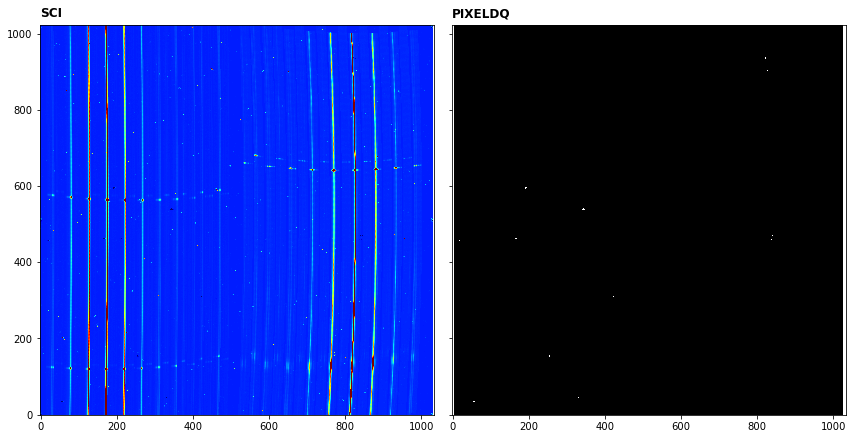

In [7]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# show last frame of first integration
axs[0].imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
axs[0].annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# plot the PIXEL_DQ frame
axs[1].imshow(dm.pixeldq, cmap='gray', interpolation='nearest', origin='lower', vmin=0, vmax=1)
axs[1].annotate('PIXELDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()
    

## SATURATION step ============================================
The saturation step flags saturated pixel for each integration by reading the calibration reference
file that specifies the saturation level for each pixel. The saturation flags are set in the fram of the GROUPDQ extension where the pixel reaches saturation. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/saturation/index.html


### SATURATION: load module and show options

In [8]:
# import the step
from jwst.saturation import saturation_step

# print the description and options
print saturation_step.SaturationStep.__doc__
print saturation_step.SaturationStep.spec



    This Step sets saturation flags.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    suffix = string(default=None)           # Default suffix for output files
    


### SATURATION: run step

In [9]:
# run the saturation step
dm = saturation_step.SaturationStep.call(dm, save_results=True, output_dir=output_dir, output_file='saturation_out.fits')

2017-08-31 07:35:00,056 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2017-08-31 07:35:00,768 - stpipe.SaturationStep - INFO - Prefetch for SATURATION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0020.fits'.
2017-08-31 07:35:00,854 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x19184ea50>,).
2017-08-31 07:35:01,321 - stpipe.SaturationStep - INFO - Using SATURATION reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0020.fits
2017-08-31 07:35:02,845 - stpipe.SaturationStep - INFO - Saving file MRS_demo_data_steps_output/saturation_out.fits
2017-08-31 07:35:04,820 - stpipe.SaturationStep - INFO - Step SaturationStep done


### SATURATION:  output check

1. saturated pixels will be flagged in the GROUPDQ extension with the number 2. Check that some pixels in this extension are now flagged as saturated

In [10]:
# check the calibration step information
print'Check saturation step information status:'
print dm.meta.cal_step.saturation

# print unique values in the GROUPDQ extension
print "\nDQ flags values in GROUPDQ extension:"
print ', '.join(map(str, np.unique(dm.groupdq)))
    

Check saturation step information status:
COMPLETE

DQ flags values in GROUPDQ extension:
0, 2


### SATURATION:  output plots

1. plot the science data

2. plot the GROUP_DQ extension to show which pixels have been flagged as saturated

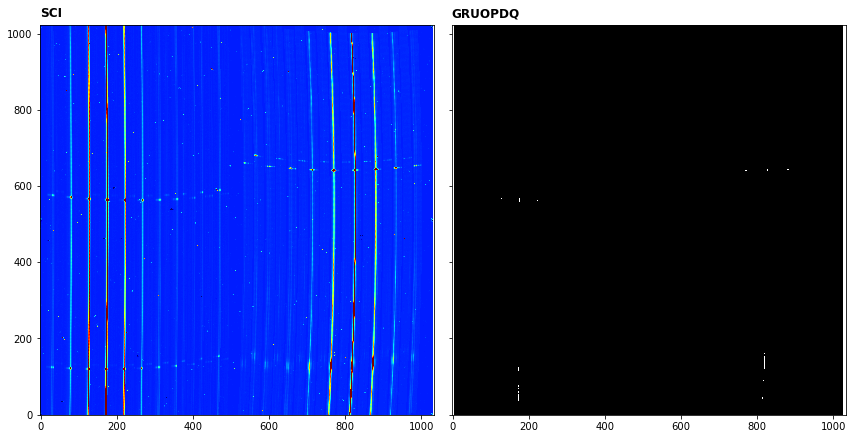

In [11]:
# plot--------------------------------------   
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# show last frame of first integration
axs[0].imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
axs[0].annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# plot last frame of first integration GROUP_DQ
axs[1].imshow(np.sum(dm.groupdq[0],axis=0), cmap='gray', interpolation='nearest', origin='lower', vmin=0, vmax=1)
axs[1].annotate('GRUOPDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()
    

## LINEARITY step ===============================================

This step corrects for detector non-linearity. The linearity coefficients are read from the linearity correction reference file.

http://ssb.stsci.edu/doc/jwst_dev/jwst/linearity/index.html


### LINEARITY: load module and show options

In [12]:
# import the step
from jwst.linearity import linearity_step

# print the description and options
print linearity_step.LinearityStep.__doc__
print linearity_step.LinearityStep.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    LinearityStep: This step performs a correction for non-linear
    detector response, using the "classic" polynomial method.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    suffix = string(default=None)           # Default suffix for output files
    


### LINEARITY: run step

In [13]:
# run the linearity step
dm = linearity_step.LinearityStep.call(dm, save_results=True, output_dir=output_dir, output_file='linearity_out.fits')

2017-08-31 07:35:08,201 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2017-08-31 07:35:08,883 - stpipe.LinearityStep - INFO - Prefetch for LINEARITY reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0023.fits'.
2017-08-31 07:35:08,947 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x191b39e50>,).
2017-08-31 07:35:09,412 - stpipe.LinearityStep - INFO - Using Linearity reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0023.fits
2017-08-31 07:35:11,989 - stpipe.LinearityStep - INFO - Saving file MRS_demo_data_steps_output/linearity_out.fits
2017-08-31 07:35:13,678 - stpipe.LinearityStep - INFO - Step LinearityStep done


### LINEARITY:  plot output science image to select pixel for inspection

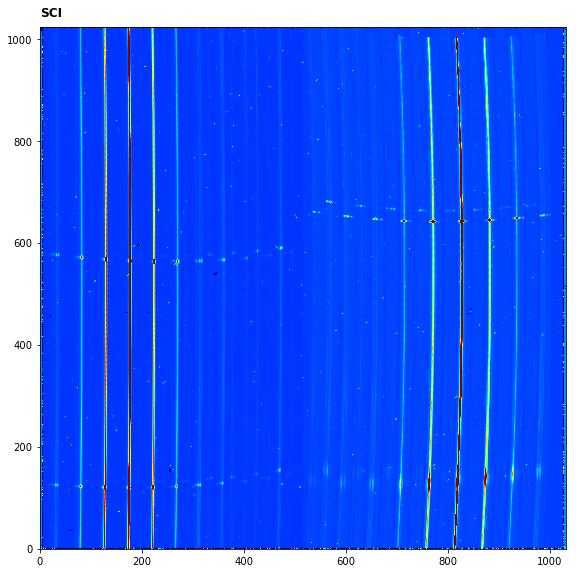

In [14]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=2e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### LINEARITY:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these

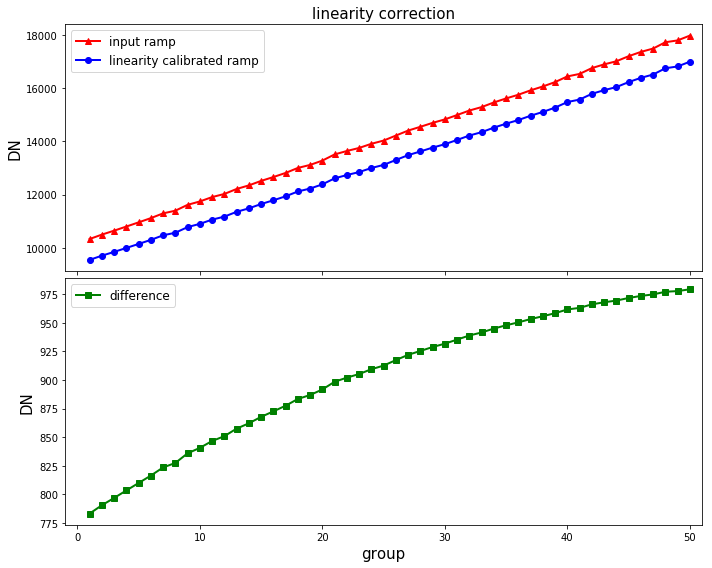

In [15]:
# using image in previous cell, select pixel to check
pixel = [130,400]

# define group numbers for integration ramps
group = range(1,in_dm.data[0,:,pixel[0],pixel[1]].shape[0]+1,1)

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot input and output ramps of the first integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='linearity calibrated ramp')
axs[0].set_title('linearity correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()



## RSCD step ======================================================
This step corrects for the slow adjustment of the reset FET to the asymtotic level after reset. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/rscd/index.html


### RSCD: load module and show options

In [16]:
# import the step
from jwst.rscd import rscd_step

# print the description and options
print rscd_step.RSCD_Step.__doc__
print rscd_step.RSCD_Step.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    RSCD_Step: Performs an RSCD correction to MIRI data by adding a function
    of time, frame by frame, to a copy of the input science data model.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    suffix = string(default=None)           # Default suffix for output files
    


#### RSCD: run step

In [17]:
# run the rscd step
dm = rscd_step.RSCD_Step.call(dm, save_results=True, output_dir=output_dir, output_file='rscd_out.fits')

2017-08-31 07:35:15,396 - stpipe.RSCD_Step - INFO - RSCD_Step instance created.
2017-08-31 07:35:16,106 - stpipe.RSCD_Step - INFO - Prefetch for RSCD reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0002.fits'.
2017-08-31 07:35:16,183 - stpipe.RSCD_Step - INFO - Step RSCD_Step running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x16b62aad0>,).
2017-08-31 07:35:16,648 - stpipe.RSCD_Step - INFO - Using RSCD reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0002.fits
2017-08-31 07:35:52,034 - stpipe.RSCD_Step - INFO - Saving file MRS_demo_data_steps_output/rscd_out.fits
2017-08-31 07:35:53,748 - stpipe.RSCD_Step - INFO - Step RSCD_Step done


### RSCD:  plot output science image to select pixel for inspection

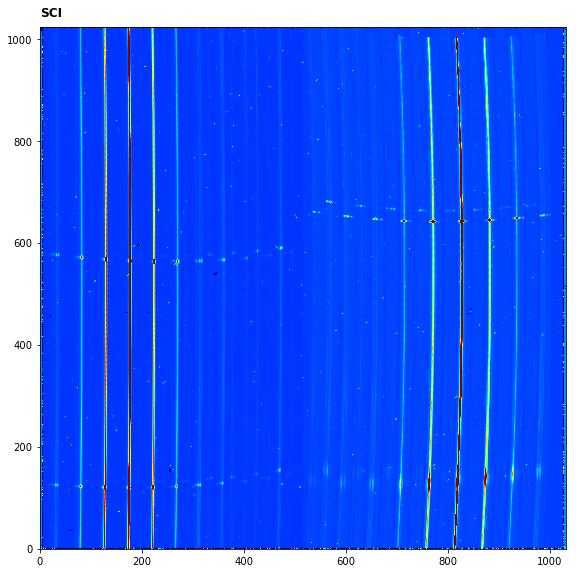

In [18]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=2e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### RSCD:  input/output ramp comparison

1. plot the input and output ramps. Note that the RSCD step only corrects following a reset show will note perform a correction if there is only one integration in the exposure.

2. show the difference between the input and output ramps


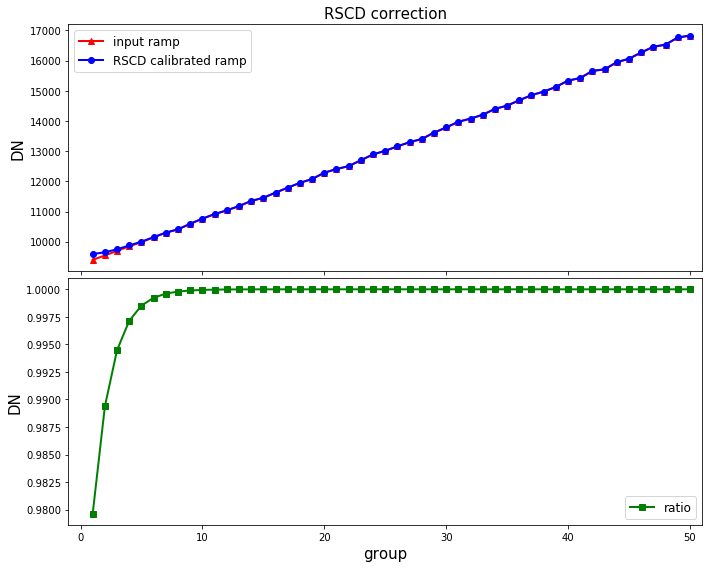

In [19]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

   
# first check that there is more than one integration
if in_dm.data.shape[0] > 1:

    # plot--------------------------------------
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # plot input and output ramps of the second integration
    axs[0].plot(group, in_dm.data[-1,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input ramp')
    axs[0].plot(group, dm.data[-1,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='RSCD calibrated ramp')
    axs[0].set_title('RSCD correction',fontsize=15)
    axs[0].set_ylabel('DN',fontsize=15)
    axs[0].set_xlim(-1,max(group)+1)
    axs[0].legend(prop={'size':12}, loc=0)

    # plot ratio between the two
    axs[1].plot(group, in_dm.data[-1,:,pixel[1],pixel[0]] / dm.data[-1,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='ratio')
    axs[1].set_ylabel('DN',fontsize=15)
    axs[1].set_xlabel('group',fontsize=15)
    axs[1].legend(prop={'size':12}, loc=0)

    plt.tight_layout(h_pad=0)
    plt.show()

else: print "RSCD step only operates on exposures with more than one integration."


## LASTFRAME step ==========================================
This step corrects for the anonolous offsets in the last frame of an integration due to the way MIRI detectors reset sequentially. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/rscd/index.html


### LASTFRAME: load module and show options

In [20]:
# import the step
from jwst.lastframe import lastframe_step

# print the description and options
print lastframe_step.LastFrameStep.__doc__
print lastframe_step.LastFrameStep.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    LastFrameStep: This is a MIRI specific task.  If the number of groups
    is greater than 1, the GROUP data quality flags for the final group will
    be set to DO_NOT_USE.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    suffix = string(default=None)           # Default suffix for output files
    


### LASTFRAME: run step

In [21]:
# run the lastframe step
dm = lastframe_step.LastFrameStep.call(dm, save_results=True, output_dir=output_dir, output_file='lastframe_out.fits')

2017-08-31 07:35:55,537 - stpipe.LastFrameStep - INFO - LastFrameStep instance created.
2017-08-31 07:35:55,792 - stpipe.LastFrameStep - INFO - Step LastFrameStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x11111ed90>,).
2017-08-31 07:35:56,780 - stpipe.LastFrameStep - INFO - Saving file MRS_demo_data_steps_output/lastframe_out.fits
2017-08-31 07:35:58,402 - stpipe.LastFrameStep - INFO - Step LastFrameStep done


### LASTFRAME:  input/output ramp comparison

This correction flags the last frame of an integration so we can check that the last frame has indeed been flagged in the groupDQ extension.

1. plot the last frame of the first integration of the GROUPDQ extension, show values of flags (should be solid colour)

2. plot the input and output GROUPDQ to show that last frame has been flagged

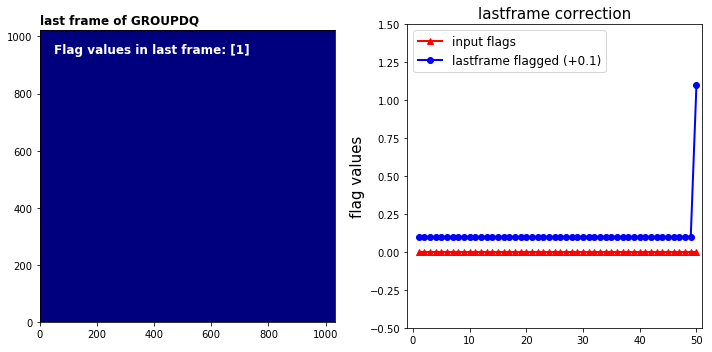

In [22]:
# define an input and output integration ramp for a given pixel
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the last frame of the first integration of the GROUPDQ extension
axs[0].imshow(dm.groupdq[-1][-1], cmap='jet', interpolation='nearest', origin='lower')
axs[0].annotate('last frame of GROUPDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# determine the values in this GROUPDQ frame
flag_values = np.unique(dm.groupdq[-1][-1])
axs[0].annotate('Flag values in last frame: %s' % flag_values, xy=(0.05, 0.92), xycoords='axes fraction', fontsize=12, fontweight='bold', color='w')

# input and output ramps (setting a slight offset for the output ramp)
axs[1].plot(group, in_dm.groupdq[-1,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input flags')
axs[1].plot(group, dm.groupdq[-1,:,pixel[1],pixel[0]]+0.1, c='b', marker='o', linestyle='-', linewidth=2, label='lastframe flagged (+0.1)')
axs[1].set_title('lastframe correction',fontsize=15)
axs[1].set_ylabel('flag values',fontsize=15)
axs[1].set_xlim(-1,max(group)+1)
axs[1].set_ylim(-0.5,1.5)
axs[1].legend(prop={'size':12}, loc=2)

plt.tight_layout(h_pad=0)
plt.show()



## DARK_CURRENT step ==========================================

This step removes the dark current by subtracting a dark current reference file.

http://ssb.stsci.edu/doc/jwst_dev/jwst/dark_current/index.html

Note that since a dark_current was not included in the MIRISim simulations that produced the demo data, we will skip the dark_current step.

### DARK_CURRENT: load module and show options

In [23]:
# import the step
from jwst.dark_current import dark_current_step

# print the description and options
print dark_current_step.DarkCurrentStep.__doc__
print dark_current_step.DarkCurrentStep.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    DarkCurrentStep: Performs dark current correction by subtracting
    dark current reference data from the input science data model.
    

        dark_output = output_file(default = None) # Dark model or averaged dark subtracted
    


### DARK_CURRENT: run step

In [24]:
# run the dark_current step
dm = dark_current_step.DarkCurrentStep.call(dm, save_results=True, output_dir=output_dir, output_file='dark_current_out.fits', skip=True)

2017-08-31 07:35:59,827 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2017-08-31 07:36:00,119 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x1045c3f10>,).
2017-08-31 07:36:00,120 - stpipe.DarkCurrentStep - INFO - Step skipped.
2017-08-31 07:36:00,128 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep done


### DARK_CURRENT:  plot output science image to select pixel for inspection

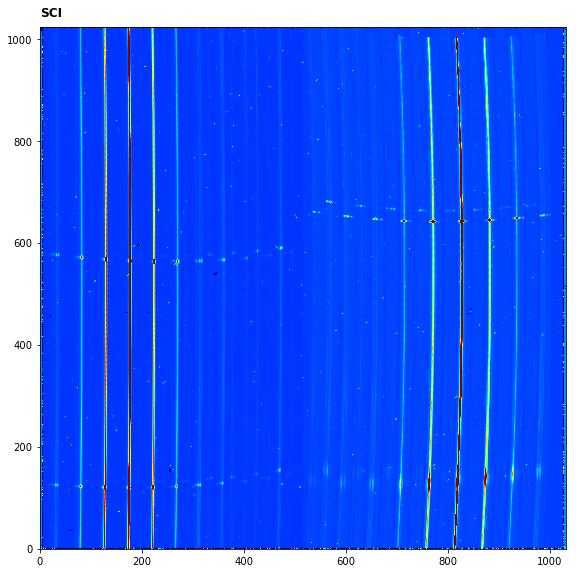

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=2e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### DARK_CURRENT:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these


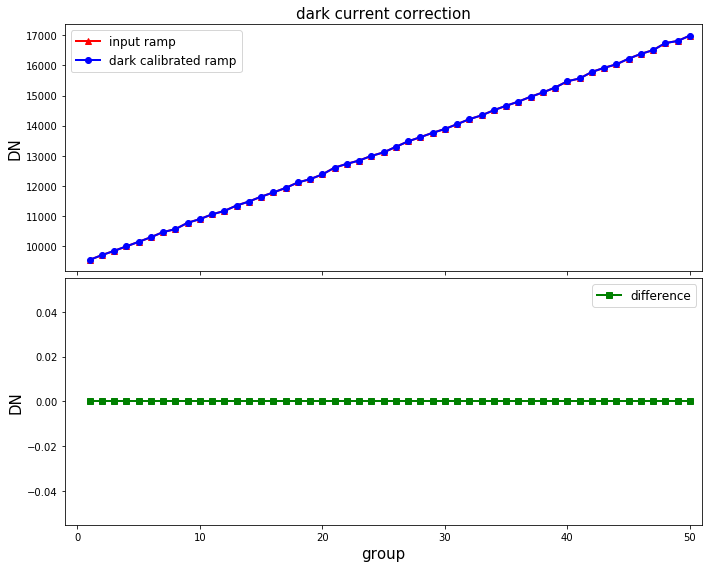

In [26]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot input and output ramps of the second integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='dark calibrated ramp')
axs[0].set_title('dark current correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference between the two
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()

## REFPIX step =============================================
This step corrects for electronic drift effects in the data by applying the reference pixel correction. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/refpix/index.html


### REFPIX: load module and show options

In [27]:
# import the step
from jwst.refpix import refpix_step

# print the description and options
print refpix_step.RefPixStep.__doc__
print refpix_step.RefPixStep.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()



    RefPixStep: Use reference pixels to correct bias drifts

    

        odd_even_columns = boolean(default=True)
        use_side_ref_pixels = boolean(default=True)
        side_smoothing_length = integer(default=11)
        side_gain = float(default=1.0)
        odd_even_rows = boolean(default=True)
    


### REFPIX: run step

In [28]:
# run the refpix step
dm = refpix_step.RefPixStep.call(dm, save_results=True, output_dir=output_dir, output_file='refpix_out.fits')

2017-08-31 07:36:02,073 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2017-08-31 07:36:02,682 - stpipe.RefPixStep - INFO - Prefetch for REFPIX reference file is 'N/A'.
2017-08-31 07:36:02,749 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x1045c3f10>,).
2017-08-31 07:36:02,885 - stpipe.RefPixStep - INFO - use_side_ref_pixels = True
2017-08-31 07:36:02,886 - stpipe.RefPixStep - INFO - odd_even_columns = True
2017-08-31 07:36:02,887 - stpipe.RefPixStep - INFO - side_smoothing_length = 11
2017-08-31 07:36:02,888 - stpipe.RefPixStep - INFO - side_gain = 1.000000
2017-08-31 07:36:02,889 - stpipe.RefPixStep - INFO - odd_even_rows = True
2017-08-31 07:36:02,891 - stpipe.RefPixStep - INFO - Subtracting initial read from each integration
2017-08-31 07:36:04,319 - stpipe.RefPixStep - INFO - Adding initial read back in
2017-08-31 07:36:06,081 - stpipe.RefPixStep - INFO - Saving file MRS_demo_data_steps_output/refpix_

### REFPIX:  plot output science image to select pixel for inspection

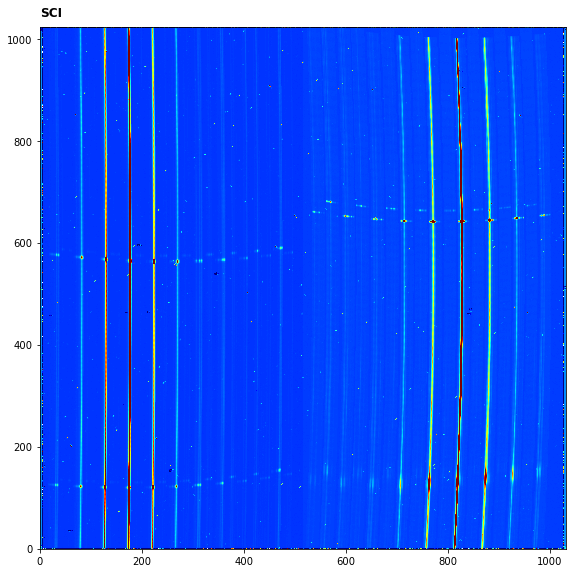

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=2e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### REFPIX:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these


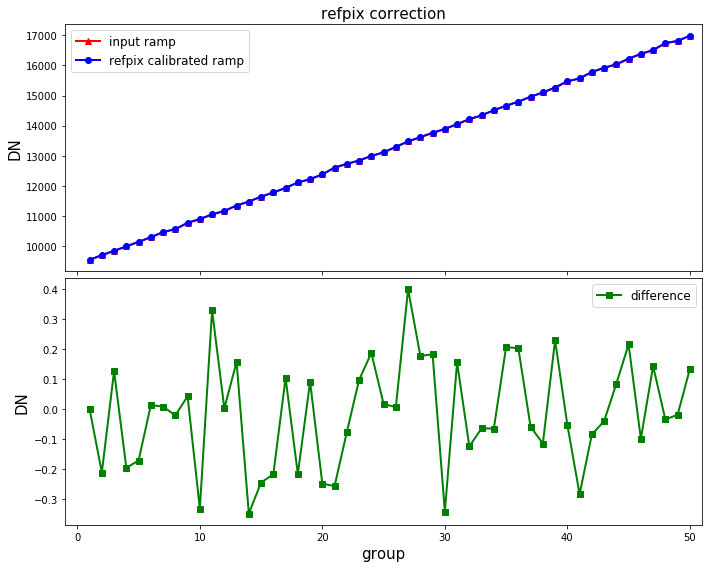

In [30]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]


# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot input and output ramps of the second integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='refpix calibrated ramp')
axs[0].set_title('refpix correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference between the two
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()

## JUMP correction =================================================

This step detects jumps in the ramp by looking for outliers from the ramp. It updates the GROUPDQ array to indicate where a jump was found.

http://ssb.stsci.edu/doc/jwst_dev/jwst/jump/index.html


### JUMP: load module and show options

In [31]:
# import the step
from jwst.jump import jump_step

# print the description and options
print jump_step.JumpStep.__doc__
print jump_step.JumpStep.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    JumpStep: Performs CR/jump detection on each ramp integration within an
    exposure. The 2-point difference method is applied.
    

        rejection_threshold = float(default=4.0,min=0) # CR rejection threshold
    


### JUMP: run step

In [32]:
# run the jump step
dm = jump_step.JumpStep.call(dm, save_results=True, output_dir=output_dir, output_file='jump_out.fits')

2017-08-31 07:36:10,030 - stpipe.JumpStep - INFO - JumpStep instance created.
2017-08-31 07:36:10,649 - stpipe.JumpStep - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits'.
2017-08-31 07:36:10,650 - stpipe.JumpStep - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits'.
2017-08-31 07:36:10,719 - stpipe.JumpStep - INFO - Step JumpStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x1123c8d50>,).
2017-08-31 07:36:10,853 - stpipe.JumpStep - INFO - CR rejection threshold = 4 sigma
2017-08-31 07:36:11,210 - stpipe.JumpStep - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2017-08-31 07:36:11,588 - stpipe.JumpStep - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2017-08

### JUMP:  plot output science image to select pixel for inspection

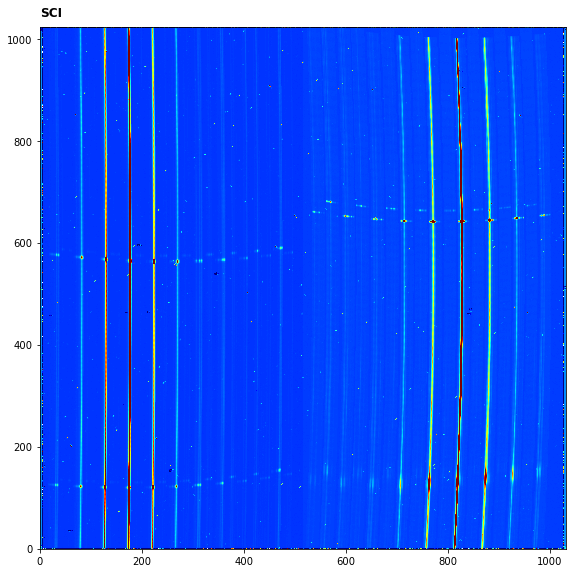

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=2e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### JUMP:  input/output ramp comparison

1. plot the output ramp

2. show the input and output GROUPDQ vectors and mark where jumps were detected (a flag of >=4 in GROUPDQ)


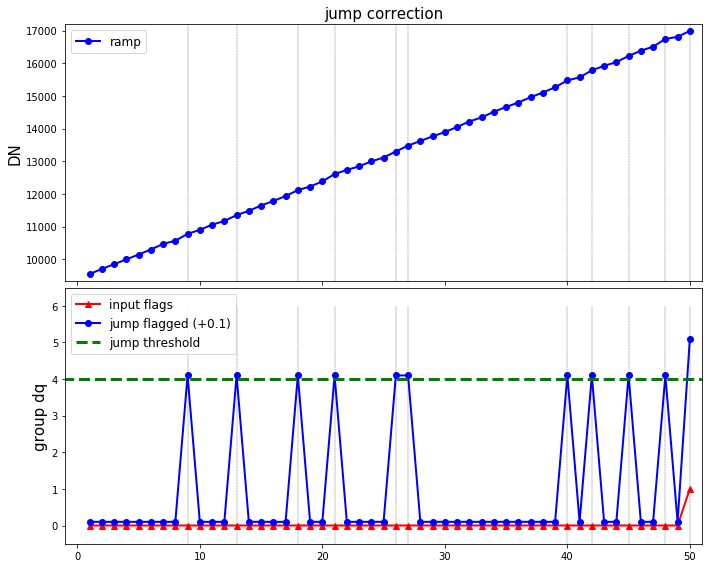

In [34]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# first integration for input/output ramps
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='ramp')
axs[0].set_title('jump correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].set_ylim(min(dm.data[0,:,pixel[1],pixel[0]])-200,max(dm.data[0,:,pixel[1],pixel[0]])+200)
axs[0].legend(prop={'size':12}, loc=2)

# input and output flag values (setting a slight offset for the output flags)
axs[1].plot(group, in_dm.groupdq[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input flags')
axs[1].plot(group, dm.groupdq[0,:,pixel[1],pixel[0]]+0.1, c='b', marker='o', linestyle='-', linewidth=2, label='jump flagged (+0.1)')
axs[1].plot([-10,100],[4,4], linestyle='--', linewidth=3, c='g', label='jump threshold')
axs[1].set_ylabel('flag values',fontsize=15)
axs[1].set_ylabel('group dq',fontsize=15)
axs[1].set_xlim(-1,max(group)+1)
axs[1].set_ylim(-0.5,6.5)
axs[1].legend(prop={'size':12}, loc=2)

# draw lines to show the groups which have been flagged as jumps
for n, val in enumerate(group):
    if (dm.groupdq[0,n,pixel[1],pixel[0]] >= 4): 
        axs[0].plot([n+1,n+1],[min(dm.data[0,:,pixel[1],pixel[0]])-200,max(dm.data[0,:,pixel[1],pixel[0]])+200], linestyle='--', linewidth=0.3, c='k')
        axs[1].plot([n+1,n+1],[-1,6], linestyle='--', linewidth=0.3, c='k')

plt.tight_layout(h_pad=0)
plt.show()


## RAMP_FITTING step =========================================

This step caculates the mean count rate for each pixel by performing a linear fit to the ramps. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/ramp_fitting/index.html

There are two outputs are here:

1) the slope image  (_rate.fits)

2) if more than one integration, slope image per integration  (_rateints.fits)


### RAMP_FITTING: load module and show options

In [35]:
# import the step
from jwst.ramp_fitting import ramp_fit_step

# print the description and options
print ramp_fit_step.RampFitStep.__doc__
print ramp_fit_step.RampFitStep.spec



    This step fits a straight line to the value of counts vs. time to
    determine the mean count rate for each pixel.
    

        int_name = string(default='')
        save_opt = boolean(default=False) # Save optional output
        opt_name = string(default='')

    


### RAMP_FITTING: run step

In [36]:
# run the ramp_fitting step
dm = ramp_fit_step.RampFitStep.call(dm, save_results=True, output_dir=output_dir)

# copy datamodel for comparison later
level2A_dm = dm.copy()

2017-08-31 07:37:00,309 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2017-08-31 07:37:01,056 - stpipe.RampFitStep - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits'.
2017-08-31 07:37:01,057 - stpipe.RampFitStep - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits'.
2017-08-31 07:37:01,135 - stpipe.RampFitStep - INFO - Step RampFitStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x111e55350>,).
2017-08-31 07:37:01,965 - stpipe.RampFitStep - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2017-08-31 07:37:01,997 - stpipe.RampFitStep - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2017-08-31 07:37:02,025 - stpipe.RampFitStep - INFO - Using algorit

### RAMP_FITTING:  level 1B and level 2A image comparison

Visually compare the input ramp and the output slope image

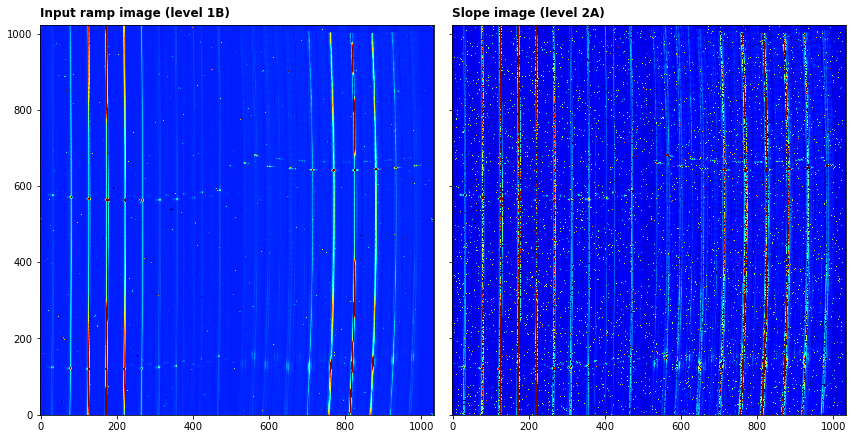

In [37]:
# open the level 1B input as a jwst data model
with datamodels.open(input_files[0]) as in_dm:

    # plot--------------------------------------
    # show the input ramp image and the calibrated
    # slope image.
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    # sum the groups in the first integration of the input ramp image and plot
    axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
    axs[0].annotate('Input ramp image (level 1B)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')
    axs[1].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
    axs[1].annotate('Slope image (level 2A)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()
    

## ASSIGN_WCS step =================================================
This step creates a WCS object and associates it with the science file, mapping detector to world coordinates. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/assign_wcs/index.html


In [38]:
# import the step
from jwst.assign_wcs import assign_wcs_step

# print the description and options
print assign_wcs_step.AssignWcsStep.__doc__
print assign_wcs_step.AssignWcsStep.spec



    AssignWcsStep: Loads all WCS and distortion information for an exposure
    and stores it in the model meta data.
    

    


### ASSIGN_WCS: run step

In [39]:
# run the assign_wcs step
dm = assign_wcs_step.AssignWcsStep.call(dm, save_results=True, output_dir=output_dir, output_file='assign_wcs_out.fits')

2017-08-31 07:40:32,062 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2017-08-31 07:40:32,636 - stpipe.AssignWcsStep - INFO - Prefetch for CAMERA reference file is 'N/A'.
2017-08-31 07:40:32,638 - stpipe.AssignWcsStep - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2017-08-31 07:40:32,639 - stpipe.AssignWcsStep - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2017-08-31 07:40:32,640 - stpipe.AssignWcsStep - INFO - Prefetch for DISTORTION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0021.asdf'.
2017-08-31 07:40:32,641 - stpipe.AssignWcsStep - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.
2017-08-31 07:40:32,642 - stpipe.AssignWcsStep - INFO - Prefetch for FORE reference file is 'N/A'.
2017-08-31 07:40:32,643 - stpipe.AssignWcsStep - INFO - Prefetch for FPA reference file is 'N/A'.
2017-08-31 07:40:32,645 - stpipe.AssignWcsStep - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2017-08-

2017-08-31 07:40:37,775 - stpipe.AssignWcsStep - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7.1rc2/lib/python2.7/site-packages/asdf/asdftypes.py:262: UserWarning: 'tag:stsci.edu:asdf/transform/scale' with version 1.0.0 found in file 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0021.asdf', but latest supported version is 1.1.0
  warnings.warn(warning_string.format(fname))

2017-08-31 07:40:37,776 - stpipe.AssignWcsStep - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7.1rc2/lib/python2.7/site-packages/asdf/asdftypes.py:240: UserWarning: 'tag:stsci.edu:asdf/transform/scale' with version 1.0.0 found in file 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0021.asdf', but latest supported version is 1.1.0
  warnings.warn(warning_string.format(fname))

2017-08-31 07:40:40,122 - stpipe.AssignWcsStep - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7.1rc2/lib/python2.7/site-packages/asdf/asdftypes.p

### ASSIGN_WCS:  plot output science image to select pixel for inspection

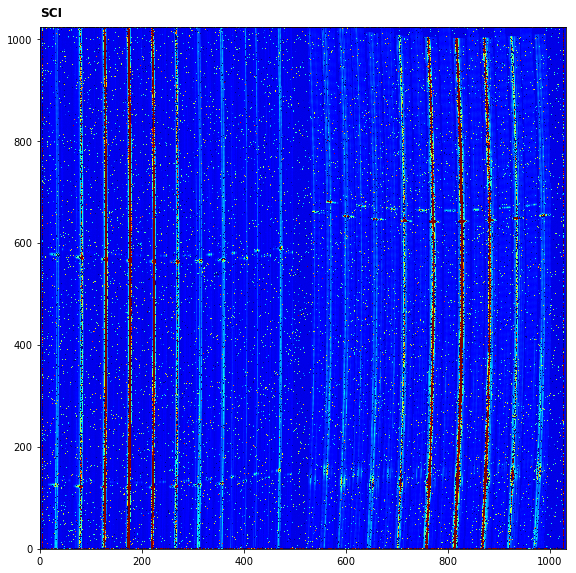

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### ASSIGN_WCS: perform some transforms

1. Display the available coordinate frames

2. perform some transfer from pixel to WCS

In [41]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# print available coordinate frames
print "Available coordinate frames:" 
print(", ".join(dm.meta.wcs.available_frames))
print ""

# perform transforms on pixel
ra, dec, wav = dm.meta.wcs(pixel[0],pixel[1])

print "Pixel: %d, %d" % (pixel[0],pixel[1])
print "assign_wcs RA, DEC (deg): %0.7f %0.7f" % (ra,dec)
print "assing_wcs Wavelength (micron): %0.3f" % wav


Available coordinate frames:
detector, alpha_beta, v2v3, world

Pixel: 130, 400
assign_wcs RA, DEC (deg): 0.0000627 -0.0000571
assing_wcs Wavelength (micron): 5.255


## FLAT_FIELD step =============================================
The flat_field step divides the image by a flat-field reference image and updates the DQ array to indicate where no flat-field is available for a pixel. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/flatfield/index.html


### FLAT_FIELD: load module and show options

In [42]:
# import the step
from jwst.flatfield import flat_field_step

# print the description and options
print flat_field_step.FlatFieldStep.__doc__
print flat_field_step.FlatFieldStep.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    FlatFieldStep: Flat-field a science image using a flatfield reference image.
    

        # Suffix for optional output file for interpolated flat fields.
        # Note that this is only used for NIRSpec spectrographic data.
        flat_suffix = string(default=None)
    


### FLAT_FIELD: run step

In [43]:
# run the flat_field step
dm = flat_field_step.FlatFieldStep.call(dm, save_results=True, output_dir=output_dir, output_file='flatfield_out.fits')

2017-08-31 07:40:50,707 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2017-08-31 07:40:52,327 - stpipe.FlatFieldStep - INFO - Prefetch for DFLAT reference file is 'N/A'.
2017-08-31 07:40:52,328 - stpipe.FlatFieldStep - INFO - Prefetch for FFLAT reference file is 'N/A'.
2017-08-31 07:40:52,330 - stpipe.FlatFieldStep - INFO - Prefetch for FLAT reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_flat_0248.fits'.
2017-08-31 07:40:52,331 - stpipe.FlatFieldStep - INFO - Prefetch for SFLAT reference file is 'N/A'.
2017-08-31 07:40:52,503 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<jwst.datamodels.image.ImageModel object at 0x116d88590>,).
2017-08-31 07:40:54,031 - stpipe.FlatFieldStep - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-31 07:40:54,832 - stpipe.FlatFieldStep - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7.1rc2/lib/python2.7/site-packages

### FLAT_FIELD: input/output image checks

1. Display the input and output images
2. Show the ratio of the two

2017-08-31 07:40:57,614 - stpipe - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7.1rc2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app



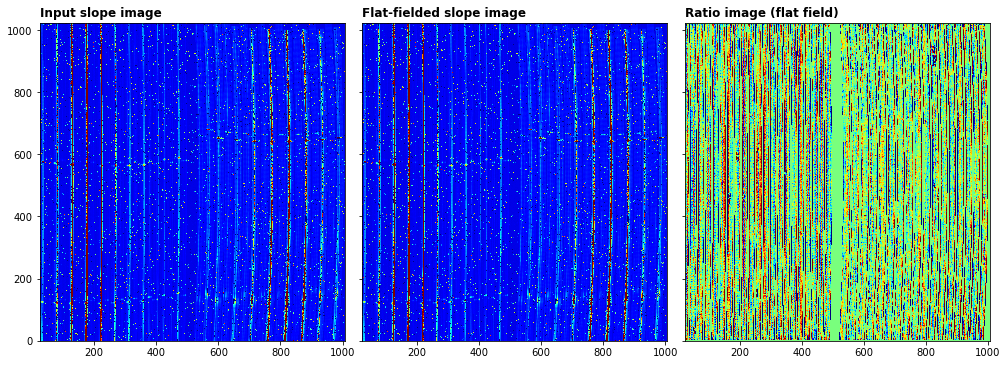

In [44]:
# plot--------------------------------------
# show the input, output and ratio image, 
# which will correspond to the flat field.
fig, axs = plt.subplots(1, 3, figsize=(14, 5),sharey=True)

# show the input
axs[0].imshow(in_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
axs[0].annotate('Input slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')

axs[1].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
axs[1].annotate('Flat-fielded slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

axs[2].imshow(in_dm.data / dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=0.98, vmax=1.02)
axs[2].annotate('Ratio image (flat field)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[2].set_facecolor('black')

plt.tight_layout()
plt.show()

## SRCTYPE step =======================================
This step checks or sets whether a spectroscopic source should be treated as a point or extended object, writing the appropriate value to a keyword. Allowable values are POINT, EXTENDED and UNKNOWN. This will usually be set from the APT by an observer. If the user sets UNKNOWN, a default of EXTENDED is set for the MRS. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/srctype/index.html


### SRCTYPE: load module and show options

In [45]:
# import the step
from jwst.srctype import srctype_step

# print the description and options
print srctype_step.SourceTypeStep.__doc__
print srctype_step.SourceTypeStep.spec



    SourceTypeStep: Selects and sets a source type based on various inputs.
    The source type is used in later calibrations to determine the appropriate
    methods to use. Input comes from either the SRCTYPE keyword value, which
    is populated from user info in the APT, or the NIRSpec MSA planning tool.
    

    


### SRCTYPE: run step

In [46]:
# run the srctype step
dm = srctype_step.SourceTypeStep.call(dm, save_results=True, output_dir=output_dir, output_file='srctype_out.fits')

2017-08-31 07:40:58,195 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.
2017-08-31 07:40:58,441 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep running with args (<jwst.datamodels.image.ImageModel object at 0x110d2d8d0>,).
2017-08-31 07:40:58,882 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is MIR_MRS
2017-08-31 07:40:58,883 - stpipe.SourceTypeStep - INFO - Input SRCTYPE is unknown. Setting to default value of EXTENDED
2017-08-31 07:40:59,240 - stpipe.SourceTypeStep - INFO - Saving file MRS_demo_data_steps_output/srctype_out.fits
2017-08-31 07:41:01,168 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep done


### SRCTYPE: check the SRCTYPE keyword value

In [47]:
# print the value of the srctype keyword
print "SRCTYPE: %s" % dm.meta.target.source_type
    

SRCTYPE: EXTENDED


 ## STRAYLIGHT step ===========================================

This step performs a straylight correction using a mask file. Straylight has only been detected for MIRI MRS short wavelength channel and only this is corrected. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/straylight/index.html

Note that MIRISim does not simulate straylight so we will skip this step

### STRAYLIGHT: load module and show options

In [48]:
from jwst.straylight import straylight_step

print straylight_step.StraylightStep.__doc__
print straylight_step.StraylightStep.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    StraylightStep: Performs straylight correction image using a Mask file.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    suffix = string(default=None)           # Default suffix for output files
    


### STRAYLIGHT: run step

In [49]:
dm = straylight_step.StraylightStep.call(dm, save_results=True, output_dir=output_dir, 
                                         output_file='straylight_out.fits', skip=True)

2017-08-31 07:41:01,977 - stpipe.StraylightStep - INFO - StraylightStep instance created.
2017-08-31 07:41:02,196 - stpipe.StraylightStep - INFO - Step StraylightStep running with args (<jwst.datamodels.image.ImageModel object at 0x111168a90>,).
2017-08-31 07:41:02,197 - stpipe.StraylightStep - INFO - Step skipped.
2017-08-31 07:41:02,594 - stpipe.StraylightStep - INFO - Step StraylightStep done


### STRAYLIGHT: show input, output and difference image (only for SHORT channel)

1. Plot input, output and difference images

In [50]:
if dm.meta.cal_step.straylight == 'COMPLETE':
    # check which channel is used and proceed if SHORT
    if in_dm.meta.instrument.detector == 'MIRIFUSHORT':

        # plot--------------------------------------
        # plot the input and output images and show
        # the difference image
        %matplotlib notebook
        from matplotlib.colors import LogNorm

        fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

        # plot the input image
        axs[0].imshow(in_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
        axs[0].annotate('input SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

        # plot the output image
        axs[1].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
        axs[1].annotate('output SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

        # look at the difference image
        axs[2].imshow((in_dm.data - dm.data), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=0.01, vmax=100))
        axs[2].annotate('Difference image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

        plt.tight_layout()
        plt.show()


    else: print 'LONG channel used, straylight step skipped'
else:
    print 'Straylight step was skipped'

Straylight step was skipped


## FRINGE step ======================================

This step applies a fringe correction to a science image using a fringe reference file. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/fringe/index.html


### FRINGE: load module and show options

In [51]:
from jwst.fringe import fringe_step

print fringe_step.FringeStep.__doc__
print fringe_step.FringeStep.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    FringeStep: Apply fringe correction to a science image using a fringe
    reference image.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    suffix = string(default=None)           # Default suffix for output files
    


### FRINGE: run step

In [52]:
dm = fringe_step.FringeStep.call(dm, save_results=True, output_dir=output_dir, output_file='fringe_out.fits')

2017-08-31 07:41:03,440 - stpipe.FringeStep - INFO - FringeStep instance created.
2017-08-31 07:41:05,206 - stpipe.FringeStep - INFO - Prefetch for FRINGE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_fringe_0031.fits'.
2017-08-31 07:41:05,374 - stpipe.FringeStep - INFO - Step FringeStep running with args (<jwst.datamodels.image.ImageModel object at 0x111168a90>,).
2017-08-31 07:41:06,982 - stpipe.FringeStep - INFO - Using FRINGE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_fringe_0031.fits
2017-08-31 07:41:07,071 - stpipe.FringeStep - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-31 07:41:07,072 - stpipe.FringeStep - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-31 07:41:07,074 - stpipe.FringeStep - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so 

### FRINGE: show input, output and difference image

1. Plot input, output
2. Plot the ratio image

2017-08-31 07:41:10,153 - stpipe - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7.1rc2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]



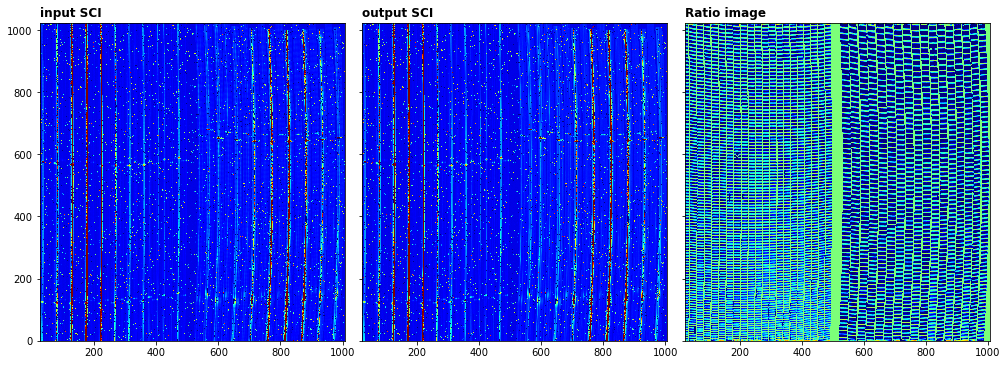

In [53]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

# plot the input image
axs[0].imshow(in_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
axs[0].annotate('input SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# plot the output image
axs[1].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
axs[1].annotate('output SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# look at the ratio image
axs[2].imshow((in_dm.data / dm.data), cmap='jet', interpolation='nearest', origin='lower', vmin=0.9, vmax=1.1)
axs[2].annotate('Ratio image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()


## PHOTOM step =======================================
This step uses spectroscopic photometric conversion reference files to convert count rates to absolute flux units. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/photom/index.html

This is the last step in the level 2b pipeline.

### PHOTOM: load module and show options

In [54]:
# import the step
from jwst.photom import photom_step

# print the description and options
print photom_step.PhotomStep.__doc__
print photom_step.PhotomStep.spec



    PhotomStep: Module for loading photometric conversion infomation from
        reference files and attaching or applying them to the input science
        data model
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    suffix = string(default=None)           # Default suffix for output files
    


### PHOTOM: run step

In [55]:
dm = photom_step.PhotomStep.call(dm, save_results=True, output_dir=output_dir, output_file='photom_out.fits')


2017-08-31 07:41:10,822 - stpipe.PhotomStep - INFO - PhotomStep instance created.
2017-08-31 07:41:12,447 - stpipe.PhotomStep - INFO - Prefetch for AREA reference file is 'N/A'.
2017-08-31 07:41:12,449 - stpipe.PhotomStep - INFO - Prefetch for PHOTOM reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0020.fits'.
2017-08-31 07:41:12,623 - stpipe.PhotomStep - INFO - Step PhotomStep running with args (<jwst.datamodels.image.ImageModel object at 0x11f7edf10>,).
2017-08-31 07:41:14,070 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0020.fits
2017-08-31 07:41:15,129 - stpipe.PhotomStep - INFO - Using area reference file: N/A
2017-08-31 07:41:15,131 - stpipe.PhotomStep - INFO - Using instrument: MIRI
2017-08-31 07:41:15,132 - stpipe.PhotomStep - INFO -  detector: MIRIFUSHORT
2017-08-31 07:41:15,133 - stpipe.PhotomStep - INFO -  exp_type: MIR_MRS
2017-08-31 07:41:15,134 

### PHOTOM: check the correct photometric keywords in output header

1. Get the photometric information from the output header

In [56]:
print "Photometric conversions (Flux density producing 1 cps)"
print "%0.2e microJy/arcsec^2" % dm.meta.photometry.conversion_microjanskys
print "%0.2e MJy/sr" % dm.meta.photometry.conversion_megajanskys


Photometric conversions (Flux density producing 1 cps)
9.99e+02 microJy/arcsec^2
4.25e+01 MJy/sr


### CALIBRATION CHECKS BEFORE CUBE_BUILDING =======================================

The level 2B file is the calibrated slope product. We can show the evolution of the data through 1B - 2A - 2B stages

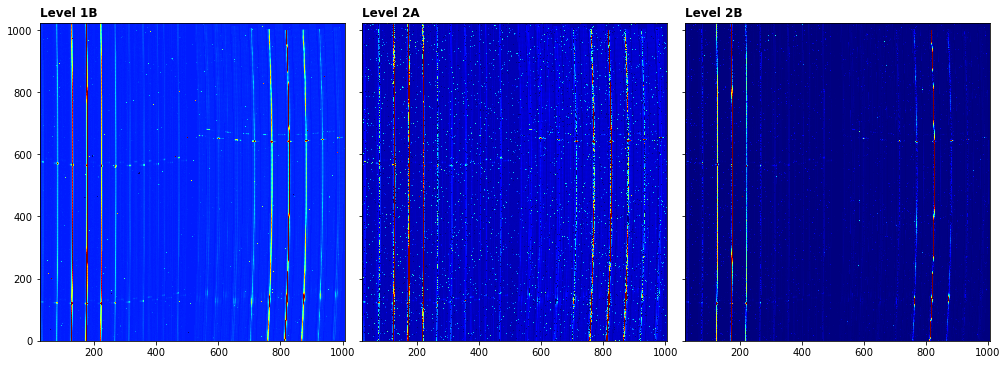

In [57]:
# open the input and output image as jwst data models
with datamodels.open(input_files[0]) as lvl1b_dm:

    # plot--------------------------------------
    # show the input ramp image and the calibrated
    # slope image.
    fig, axs = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

    # 1B image
    axs[0].imshow(lvl1b_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
    axs[0].annotate('Level 1B', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')

    # 2A image
    axs[1].imshow(level2A_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=20)
    axs[1].annotate('Level 2A', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')

    # 2B image
    axs[2].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=1e3)
    axs[2].annotate('Level 2B', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[2].set_facecolor('black')

    plt.tight_layout()
    plt.show()

## CUBE_BUILD step ======================================
This step builds a cube from the level 2B file See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/cube_build/index.html


### CUBE_BUILD: load module and show options

In [58]:
# import the step
from jwst.cube_build import cube_build_step

# print the description and options
print cube_build_step.CubeBuildStep.__doc__
print cube_build_step.CubeBuildStep.spec



    CubeBuildStep: Creates a 3-D spectral cube from a given association, single model,
    single input file, or model container.
    Input parameters allow the spectral cube to be built from a provided
    channel/subchannel (MIRI) or grating/filer  (NIRSPEC)
    

         channel = option('1','2','3','4','ALL','all',default='ALL')
         band = option('SHORT','MEDIUM','LONG','ALL','short','medium','long','all',default='ALL')
         grating   = option('PRISIM','G140M','G140H','G235M','G235H',G395M','G395H','ALL','all',default='ALL')
         filter   = option('CLEAR','F100LP','F070LP','F170LP','F290LP','ALL','all',default='ALL')
         scale1 = float(default=0.0)
         scale2 = float(default=0.0)
         scalew = float(default=0.0)
         weighting = option('msm','miripsf','area','MSM','MIRIPSF','AREA',default = 'msm')
         coord_system = option('ra-dec','alpha-beta','ALPHA-BETA',default='ra-dec')
         rois = float(default=0.0)
         roiw = float(default=0.0)


### CUBE_BUILD: show some observation parameters in case user wants to set options

In [59]:
# show observation parameters
print "detector: %s" % dm.meta.instrument.detector
print "channel: %s" % dm.meta.instrument.channel
print "band: %s" % dm.meta.instrument.band

detector: MIRIFUSHORT
channel: 12
band: SHORT


### CUBE_BUILD: run step
We will select to build a cube from channel 1 only to avoid large gaps in the wavelength direction between channels 1 and 2. 

In [60]:
# run cube_build step
cube_dm = cube_build_step.CubeBuildStep.call(dm, channel='1', band='SHORT', save_results=True, output_dir=output_dir, output_file='cube_build_out.fits') 

2017-08-31 07:41:21,056 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2017-08-31 07:41:23,004 - stpipe.CubeBuildStep - INFO - Prefetch for CUBEPAR reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_cubepar_0001.fits'.
2017-08-31 07:41:23,005 - stpipe.CubeBuildStep - INFO - Prefetch for RESOL reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_resol_0003.fits'.
2017-08-31 07:41:23,189 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep running with args (<jwst.datamodels.image.ImageModel object at 0x110edd090>,).
2017-08-31 07:41:23,190 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step
2017-08-31 07:41:23,191 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud
2017-08-31 07:41:23,192 - stpipe.CubeBuildStep - INFO - Coordinate system to use: ra-dec
2017-08-31 07:41:23,194 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: msm
2017-08-31 07:41:23,195 - stpipe.CubeBu

### CUBE_BUILD: show output cube

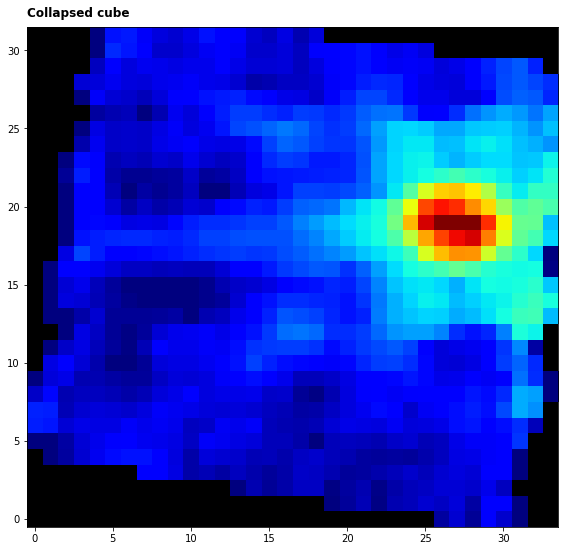

In [61]:
# plot--------------------------------------
# sum the frames of the first integration and plot
# Note the user may have to adjust the scaling
# parameters
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

axs.imshow(np.sum(cube_dm.data, axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=5e2,vmax=1e6))
axs.annotate('Collapsed cube', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()

## EXTRACT_1D step ======================================
This step extracts a 1D spectrum from the cube. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/extract_1d/index.html


### EXTRACT_1D: load module and show options

In [62]:
# import the step
from jwst.extract_1d import extract_1d_step

# print the description and options
print extract_1d_step.Extract1dStep.__doc__
print extract_1d_step.Extract1dStep.spec



    Extract1dStep: Extract a 1-d spectrum from 2-d data
    

    # Boxcar smoothing width for background regions.
    smoothing_length = integer(default=None)
    # Order of polynomial fit to one column (or row if the dispersion
    # direction is vertical) of background regions.
    bkg_order = integer(default=None, min=0)
    


### EXTRACT_1D: run step

In [63]:
spec_dm = extract_1d_step.Extract1dStep.call(cube_dm, save_results=True, output_dir=output_dir, output_file='extract_1d_out.fits')

2017-08-31 07:41:56,989 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2017-08-31 07:41:58,066 - stpipe.Extract1dStep - INFO - Prefetch for EXTRACT1D reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json'.
2017-08-31 07:41:58,263 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<jwst.datamodels.ifucube.IFUCubeModel object at 0x11f843290>,).
2017-08-31 07:41:59,133 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2017-08-31 07:41:59,249 - stpipe.Extract1dStep - INFO - source_type = extended
2017-08-31 07:41:59,882 - stpipe.Extract1dStep - INFO - Data have been flux calibrated; setting net to 0.
2017-08-31 07:42:00,148 - stpipe.Extract1dStep - INFO - Saving file MRS_demo_data_steps_output/extract_1d_out.fits
2017-08-31 07:42:00,267 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


### EXTRACT_1D: plot spectrum

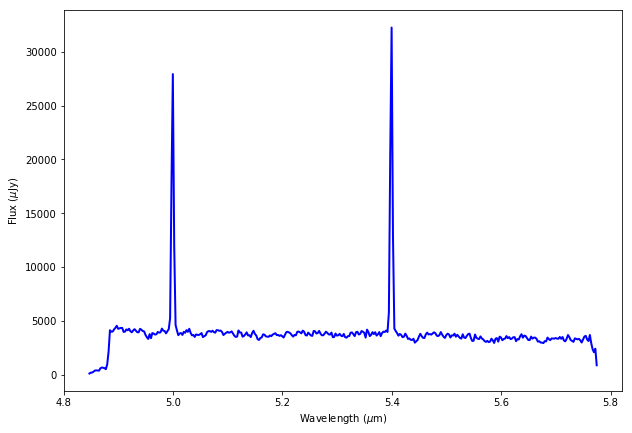

In [64]:
# plot--------------------------------------
# simple XY plot of the spectrum
fig, axs = plt.subplots(1, 1, figsize=(10, 7))

spec = spec_dm.spec[0]

axs.plot(spec.spec_table['WAVELENGTH'], spec.spec_table['FLUX'], c='b', marker='.', markersize=0, linestyle='-', linewidth=2)
axs.set_ylabel(r'Flux ($\mu$Jy)')
axs.set_xlabel(r'Wavelength ($\mu$m)')

plt.show()

## BRING DITHERS TO LEVEL 2B FOR LEVEL 3 PROCESSING

In [65]:
from jwst.pipeline import SloperPipeline
from jwst.pipeline import Spec2Pipeline

for input_file in input_files:
    with datamodels.open(input_file) as dm_1B:
        dm_2A = SloperPipeline.call(dm_1B, save_results=True, output_dir=output_dir, 
                                    steps={'dark_current':{'skip':True}})
        dm_2B = Spec2Pipeline.call(dm_2A, save_results=True, output_dir=output_dir, 
                                   steps={'straylight':{'skip':True},'cube_build':{'save_results':True},
                                          'extract_1d':{'save_results':True}})
        
# create and load association
cal_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))
call(["asn_from_list", "-o", "MRS_asn.json"] + cal_files + ["--product-name", "dither"])
dms = datamodels.open("MRS_asn.json")

2017-08-31 07:42:02,171 - stpipe.SloperPipeline - INFO - SloperPipeline instance created.
2017-08-31 07:42:02,173 - stpipe.SloperPipeline.group_scale - INFO - GroupScaleStep instance created.
2017-08-31 07:42:02,175 - stpipe.SloperPipeline.saturation - INFO - SaturationStep instance created.
2017-08-31 07:42:02,178 - stpipe.SloperPipeline.rscd - INFO - RSCD_Step instance created.
2017-08-31 07:42:02,180 - stpipe.SloperPipeline.ipc - INFO - IPCStep instance created.
2017-08-31 07:42:02,182 - stpipe.SloperPipeline.ramp_fit - INFO - RampFitStep instance created.
2017-08-31 07:42:02,185 - stpipe.SloperPipeline.linearity - INFO - LinearityStep instance created.
2017-08-31 07:42:02,187 - stpipe.SloperPipeline.jump - INFO - JumpStep instance created.
2017-08-31 07:42:02,189 - stpipe.SloperPipeline.refpix - INFO - RefPixStep instance created.
2017-08-31 07:42:02,191 - stpipe.SloperPipeline.lastframe - INFO - LastFrameStep instance created.
2017-08-31 07:42:02,192 - stpipe.SloperPipeline.dq_ini

2017-08-31 07:43:15,193 - stpipe.SloperPipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2017-08-31 07:43:16,457 - stpipe.SloperPipeline.jump - INFO - Executing two-point difference method
2017-08-31 07:43:52,672 - stpipe.SloperPipeline.jump - INFO - Step jump done
2017-08-31 07:43:53,890 - stpipe.SloperPipeline.ramp_fit - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits'.
2017-08-31 07:43:53,891 - stpipe.SloperPipeline.ramp_fit - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits'.
2017-08-31 07:43:54,097 - stpipe.SloperPipeline.ramp_fit - INFO - Step ramp_fit running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x11f793950>,).
2017-08-31 07:43:55,759 - stpipe.SloperPipeline.ramp_fit - INFO - Using READNOISE reference fil

2017-08-31 07:47:42,567 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<jwst.datamodels.image.ImageModel object at 0x10ad2d110>,).
2017-08-31 07:47:42,568 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.
2017-08-31 07:47:42,913 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done
2017-08-31 07:47:44,893 - stpipe.Spec2Pipeline.fringe - INFO - Prefetch for FRINGE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_fringe_0031.fits'.
2017-08-31 07:47:45,150 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<jwst.datamodels.image.ImageModel object at 0x10ad2d110>,).
2017-08-31 07:47:46,892 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_fringe_0031.fits
2017-08-31 07:47:46,997 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ign

2017-08-31 07:49:22,085 - stpipe.SloperPipeline.rscd - INFO - RSCD_Step instance created.
2017-08-31 07:49:22,087 - stpipe.SloperPipeline.ipc - INFO - IPCStep instance created.
2017-08-31 07:49:22,089 - stpipe.SloperPipeline.ramp_fit - INFO - RampFitStep instance created.
2017-08-31 07:49:22,091 - stpipe.SloperPipeline.linearity - INFO - LinearityStep instance created.
2017-08-31 07:49:22,094 - stpipe.SloperPipeline.jump - INFO - JumpStep instance created.
2017-08-31 07:49:22,096 - stpipe.SloperPipeline.refpix - INFO - RefPixStep instance created.
2017-08-31 07:49:22,098 - stpipe.SloperPipeline.lastframe - INFO - LastFrameStep instance created.
2017-08-31 07:49:22,101 - stpipe.SloperPipeline.dq_init - INFO - DQInitStep instance created.
2017-08-31 07:49:22,103 - stpipe.SloperPipeline.dark_current - INFO - DarkCurrentStep instance created.
2017-08-31 07:49:22,105 - stpipe.SloperPipeline.persistence - INFO - PersistenceStep instance created.
2017-08-31 07:49:22,107 - stpipe.SloperPipelin

2017-08-31 07:51:18,574 - stpipe.SloperPipeline.jump - INFO - Step jump done
2017-08-31 07:51:20,164 - stpipe.SloperPipeline.ramp_fit - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits'.
2017-08-31 07:51:20,165 - stpipe.SloperPipeline.ramp_fit - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits'.
2017-08-31 07:51:20,449 - stpipe.SloperPipeline.ramp_fit - INFO - Step ramp_fit running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x148168e50>,).
2017-08-31 07:51:22,554 - stpipe.SloperPipeline.ramp_fit - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2017-08-31 07:51:22,609 - stpipe.SloperPipeline.ramp_fit - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2017-08-31 07:51:

2017-08-31 07:55:18,360 - stpipe.Spec2Pipeline.fringe - INFO - Prefetch for FRINGE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_fringe_0031.fits'.
2017-08-31 07:55:18,723 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<jwst.datamodels.image.ImageModel object at 0x14c72e550>,).
2017-08-31 07:55:20,770 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_fringe_0031.fits
2017-08-31 07:55:20,889 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-31 07:55:20,890 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-31 07:55:20,892 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-31

2017-08-31 07:56:57,272 - stpipe.SloperPipeline.jump - INFO - JumpStep instance created.
2017-08-31 07:56:57,274 - stpipe.SloperPipeline.refpix - INFO - RefPixStep instance created.
2017-08-31 07:56:57,276 - stpipe.SloperPipeline.lastframe - INFO - LastFrameStep instance created.
2017-08-31 07:56:57,278 - stpipe.SloperPipeline.dq_init - INFO - DQInitStep instance created.
2017-08-31 07:56:57,280 - stpipe.SloperPipeline.dark_current - INFO - DarkCurrentStep instance created.
2017-08-31 07:56:57,282 - stpipe.SloperPipeline.persistence - INFO - PersistenceStep instance created.
2017-08-31 07:56:57,284 - stpipe.SloperPipeline.superbias - INFO - SuperBiasStep instance created.
2017-08-31 07:56:57,763 - stpipe.SloperPipeline - INFO - Step SloperPipeline running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x16b977110>,).
2017-08-31 07:56:57,765 - stpipe.SloperPipeline - INFO - Starting calwebb_sloper ...
2017-08-31 07:56:58,259 - stpipe.SloperPipeline.group_scale - INFO - St

2017-08-31 07:59:01,811 - stpipe.SloperPipeline.ramp_fit - INFO - Step ramp_fit running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x14d6b7fd0>,).
2017-08-31 07:59:04,436 - stpipe.SloperPipeline.ramp_fit - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2017-08-31 07:59:04,506 - stpipe.SloperPipeline.ramp_fit - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2017-08-31 07:59:04,573 - stpipe.SloperPipeline.ramp_fit - INFO - Using algorithm = ols
2017-08-31 07:59:04,574 - stpipe.SloperPipeline.ramp_fit - INFO - Using weighting = optimal
2017-08-31 07:59:04,592 - stpipe.SloperPipeline.ramp_fit - INFO - Effective integration time per group: 2.77504
2017-08-31 08:02:25,477 - stpipe.SloperPipeline.ramp_fit - INFO - Number of groups per integration: 50
2017-08-31 08:02:25,478 - stpipe.SloperPipeline.ramp_fit - INFO - Number of integ

2017-08-31 08:03:10,971 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-31 08:03:10,973 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-31 08:03:10,975 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-31 08:03:11,860 - stpipe.Spec2Pipeline.fringe - INFO - The DQ values in the reference file will NOT be used to update the    DQ values in the output DQ array.
2017-08-31 08:03:12,149 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done
2017-08-31 08:03:14,746 - stpipe.Spec2Pipeline.photom - INFO - Prefetch for AREA reference file is 'N/A'.
2017-08-31 08:03:14,748 - stpipe.Spec2Pipeline.photom - INFO - Prefetch for PHOTOM reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photo

2017-08-31 08:04:50,508 - stpipe.SloperPipeline.persistence - INFO - PersistenceStep instance created.
2017-08-31 08:04:50,510 - stpipe.SloperPipeline.superbias - INFO - SuperBiasStep instance created.
2017-08-31 08:04:51,069 - stpipe.SloperPipeline - INFO - Step SloperPipeline running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x11f59a650>,).
2017-08-31 08:04:51,071 - stpipe.SloperPipeline - INFO - Starting calwebb_sloper ...
2017-08-31 08:04:51,656 - stpipe.SloperPipeline.group_scale - INFO - Step group_scale running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x14c109f50>,).
2017-08-31 08:04:51,789 - stpipe.SloperPipeline.group_scale - WARNING - NFRAMES=1 is a power of 2
2017-08-31 08:04:51,790 - stpipe.SloperPipeline.group_scale - WARNING - Step will be skipped
2017-08-31 08:04:51,797 - stpipe.SloperPipeline.group_scale - INFO - Step group_scale done
2017-08-31 08:04:53,871 - stpipe.SloperPipeline.dq_init - INFO - Prefetch for MASK reference fil

2017-08-31 08:07:05,548 - stpipe.SloperPipeline.ramp_fit - INFO - Using algorithm = ols
2017-08-31 08:07:05,549 - stpipe.SloperPipeline.ramp_fit - INFO - Using weighting = optimal
2017-08-31 08:07:05,567 - stpipe.SloperPipeline.ramp_fit - INFO - Effective integration time per group: 2.77504
2017-08-31 08:10:27,075 - stpipe.SloperPipeline.ramp_fit - INFO - Number of groups per integration: 50
2017-08-31 08:10:27,076 - stpipe.SloperPipeline.ramp_fit - INFO - Number of integrations: 2
2017-08-31 08:10:27,305 - stpipe.SloperPipeline.ramp_fit - INFO - Step.save_model MRS_demo_data_steps_output/det_image_seq4_MIRIFUSHORT_12SHORTexp1_rateints.fits
2017-08-31 08:10:27,500 - stpipe.SloperPipeline.ramp_fit - INFO - Step ramp_fit done
2017-08-31 08:10:27,501 - stpipe.SloperPipeline - INFO - ... ending calwebb_sloper
2017-08-31 08:10:27,509 - stpipe.SloperPipeline - INFO - Saving file MRS_demo_data_steps_output/det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits
2017-08-31 08:10:27,680 - stpipe.Slope

2017-08-31 08:11:19,823 - stpipe.Spec2Pipeline.fringe - INFO - The DQ values in the reference file will NOT be used to update the    DQ values in the output DQ array.
2017-08-31 08:11:20,110 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done
2017-08-31 08:11:22,991 - stpipe.Spec2Pipeline.photom - INFO - Prefetch for AREA reference file is 'N/A'.
2017-08-31 08:11:22,992 - stpipe.Spec2Pipeline.photom - INFO - Prefetch for PHOTOM reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0020.fits'.
2017-08-31 08:11:23,529 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<jwst.datamodels.image.ImageModel object at 0x152fb9750>,).
2017-08-31 08:11:25,949 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0020.fits
2017-08-31 08:11:27,982 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2017-08-31 08:11:27,984 - stpipe.Spec

## MRS_IMATCH step ======================================
This step “matches” image intensities of several input 2D MIRI MRS images by fitting polynomials to cube intensities (cubes built from input 2D images) in such a way as to minimize inter-image mismatch in the least squares sense.  See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/mrs_imatch/index.html

Note that by default this step adds the determined polynomials to each input datamodel but does not subtract them. This funcitonality must be set by the user with the 'subtract' option.

### MRS_IMATCH: load module and show options

In [66]:
# import the step
from jwst.mrs_imatch import mrs_imatch_step

# print the description and options
print mrs_imatch_step.MRSIMatchStep.__doc__
print mrs_imatch_step.MRSIMatchStep.spec



    MRSIMatchStep: Subtraction or equalization of sky background in MIRI MRS science images.

    

        # General sky matching parameters:
        bkg_degree = integer(min=0, default=1) # Degree of the polynomial for background fitting
        subtract = boolean(default=False) # subtract computed sky from 'images' cube data?

    


### MRS_IMATCH: run step

In [67]:
dms = mrs_imatch_step.MRSIMatchStep.call(dms)

2017-08-31 08:13:00,437 - stpipe.MRSIMatchStep - INFO - MRSIMatchStep instance created.
2017-08-31 08:13:01,160 - stpipe.MRSIMatchStep - INFO - Step MRSIMatchStep running with args (<jwst.datamodels.container.ModelContainer object at 0x150bbbdd0>,).
2017-08-31 08:13:28,183 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2017-08-31 08:13:28,184 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step
2017-08-31 08:13:28,185 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud
2017-08-31 08:13:28,186 - stpipe.CubeBuildStep - INFO - Coordinate system to use: ra-dec
2017-08-31 08:13:28,188 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: msm
2017-08-31 08:13:28,189 - stpipe.CubeBuildStep - INFO - Power Weighting distance : 2.000000
2017-08-31 08:13:28,190 - stpipe.CubeBuildStep - INFO -  Single = true, creating a set of single exposures mapped to output IFUCube coordinate system
2017-08-31 08:13:32,598 - stpipe.MRSIMatchStep - INFO - The d

### MRS_IMATCH: check background metadata

1. Check that the determined polynomial info for the first dither only

In [68]:
import pprint

print dms[0].meta.filename + ':'
print pprint.pprint(dms[0].meta.background.polynomial_info)
    

det_image_seq1_MIRIFUSHORT_12SHORTexp1_cal.fits:
[{u'wcs': <WCS(output_frame=world, input_frame=None, forward_transform=Model: CompoundModel9039
Inputs: (u'x0', u'x1', u'x')
Outputs: (u'alpha_C', u'delta_C', u'x')
Model set size: 1
Expression: ([0] & [1] | [2] | [3] & [4] | [5] | [6]) & ([7] | [8] | [9])
Components: 
    [0]: <Shift(offset=-26.0, name=u'crpix1')>

    [1]: <Shift(offset=-19.0, name=u'crpix2')>

    [2]: <AffineTransformation2D(matrix=[[ 1., 0.], [ 0., 1.]], translation=[ 0., 0.], name=u'pc_matrix')>

    [3]: <Scale(factor=3.6111109786563447e-05, name=u'cdelt1')>

    [4]: <Scale(factor=3.6111109786563447e-05, name=u'cdelt2')>

    [5]: <Pix2Sky_Gnomonic(name='TAN')>

    [6]: <RotateNative2Celestial(lon=-1.6376430947558584e-05, lat=-7.714131695848157e-06, lon_pole=180.0, name=u'crval')>

    [7]: <Shift(offset=-0.0)>

    [8]: <Scale(factor=0.0024999999441206455)>

    [9]: <Shift(offset=4.847113736591551)>
Parameters:
    offset_0 offset_1 matrix_2 [2,2] ... offset_7

## OUTLIER_DETECTION step ======================================
Flag outlier bad pixels and cosmic rays in the DQ array of each input image. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/outlier_detection/index.html

Note that there is currently a problem running the demo data through this step so we skip it for now

### OUTLIER_DETECTION: load module and show options

In [69]:
# import the step
from jwst.outlier_detection import outlier_detection_step

# print the description and options
print outlier_detection_step.OutlierDetectionStep.__doc__
print outlier_detection_step.OutlierDetectionStep.spec



    Flag outlier bad pixels and cosmic rays in the DQ array of each input image

    Input images can listed in an input association file or already opened
    with a ModelContainer.  DQ arrays are modified in place.

    Parameters
    -----------
    input : asn file or ModelContainer
        Single filename association table, or a datamodels.ModelContainer.
    

        wht_type = option('exptime','error',None,default='exptime')
        pixfrac = float(default=1.0)
        kernel = string(default='square') # drizzle kernel
        fillval = string(default='INDEF')
        nlow = integer(default=0)
        nhigh = integer(default=0)
        maskpt = float(default=0.7)
        grow = integer(default=1)
        snr = string(default='4.0 3.0')
        scale = string(default='0.5 0.4')
        backg = float(default=0.0)
        save_intermediate_results = boolean(default=False)
        resample_data = boolean(default=True)
        good_bits = integer(default=4)
    


### OUTLIER_DETECTION: run step

In [70]:
# run step
dms = outlier_detection_step.OutlierDetectionStep.call(dms, skip=True)


2017-08-31 08:18:38,813 - stpipe.OutlierDetectionStep - INFO - OutlierDetectionStep instance created.
2017-08-31 08:18:39,801 - stpipe.OutlierDetectionStep - INFO - Step OutlierDetectionStep running with args (<jwst.datamodels.container.ModelContainer object at 0x150bbbdd0>,).
2017-08-31 08:18:39,802 - stpipe.OutlierDetectionStep - INFO - Step skipped.
2017-08-31 08:18:39,806 - stpipe.OutlierDetectionStep - INFO - Step OutlierDetectionStep done


## CUBE_BUILD step ======================================
In the level 3 pipeline, this step builds a cube from all level 2B files in the association, i.e., combining the dithers. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/cube_build/index.html


### CUBE_BUILD: load module and show options

In [71]:
from jwst.cube_build import cube_build_step

# print the description and options
print cube_build_step.CubeBuildStep.__doc__
print cube_build_step.CubeBuildStep.spec



    CubeBuildStep: Creates a 3-D spectral cube from a given association, single model,
    single input file, or model container.
    Input parameters allow the spectral cube to be built from a provided
    channel/subchannel (MIRI) or grating/filer  (NIRSPEC)
    

         channel = option('1','2','3','4','ALL','all',default='ALL')
         band = option('SHORT','MEDIUM','LONG','ALL','short','medium','long','all',default='ALL')
         grating   = option('PRISIM','G140M','G140H','G235M','G235H',G395M','G395H','ALL','all',default='ALL')
         filter   = option('CLEAR','F100LP','F070LP','F170LP','F290LP','ALL','all',default='ALL')
         scale1 = float(default=0.0)
         scale2 = float(default=0.0)
         scalew = float(default=0.0)
         weighting = option('msm','miripsf','area','MSM','MIRIPSF','AREA',default = 'msm')
         coord_system = option('ra-dec','alpha-beta','ALPHA-BETA',default='ra-dec')
         rois = float(default=0.0)
         roiw = float(default=0.0)


### CUBE_BUILD: run step

In [72]:
# run step
cube_dm = cube_build_step.CubeBuildStep.call(dms, save_results=True, output_dir=output_dir)

2017-08-31 08:18:39,823 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2017-08-31 08:18:44,064 - stpipe.CubeBuildStep - INFO - Prefetch for CUBEPAR reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_cubepar_0001.fits'.
2017-08-31 08:18:44,065 - stpipe.CubeBuildStep - INFO - Prefetch for RESOL reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_resol_0003.fits'.
2017-08-31 08:18:46,399 - stpipe.CubeBuildStep - INFO - Prefetch for CUBEPAR reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_cubepar_0001.fits'.
2017-08-31 08:18:46,400 - stpipe.CubeBuildStep - INFO - Prefetch for RESOL reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_resol_0003.fits'.
2017-08-31 08:18:48,811 - stpipe.CubeBuildStep - INFO - Prefetch for CUBEPAR reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_cubepar_0001.fits'.
2017-08-31

### CUBE_BUILD: plot the channels of the cube

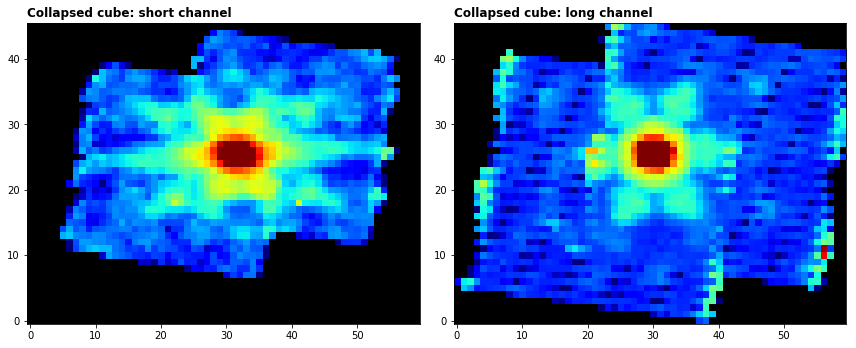

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.sum(cube_dm.data[100:300], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=100,vmax=5e4))
axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')
axs[1].imshow(np.sum(cube_dm.data[1200:1400], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=400,vmax=5e4))
axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()

## EXTRACT_1D step ======================================
In the level 3 pipeline, this step extracts a 1D spectrum from the combined cube. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/extract_1d/index.html


### EXTRACT_1D: load module and show options

In [74]:
from jwst.extract_1d import extract_1d_step

# print the description and options
print extract_1d_step.Extract1dStep.__doc__
print extract_1d_step.Extract1dStep.spec


    Extract1dStep: Extract a 1-d spectrum from 2-d data
    

    # Boxcar smoothing width for background regions.
    smoothing_length = integer(default=None)
    # Order of polynomial fit to one column (or row if the dispersion
    # direction is vertical) of background regions.
    bkg_order = integer(default=None, min=0)
    


### EXTRACT_1D: run step

In [75]:
# run step
spec_dm = extract_1d_step.Extract1dStep.call(cube_dm, save_results=True, output_dir=output_dir)

2017-08-31 08:22:25,795 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2017-08-31 08:22:29,789 - stpipe.Extract1dStep - INFO - Prefetch for EXTRACT1D reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json'.
2017-08-31 08:22:30,654 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<jwst.datamodels.ifucube.IFUCubeModel object at 0x1e0f67d50>,).
2017-08-31 08:22:33,652 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2017-08-31 08:22:33,892 - stpipe.Extract1dStep - INFO - source_type = extended
2017-08-31 08:22:36,306 - stpipe.Extract1dStep - INFO - Data have been flux calibrated; setting net to 0.
2017-08-31 08:22:36,803 - stpipe.Extract1dStep - INFO - Saving file MRS_demo_data_steps_output/dither_ch1-2-short_extract1dstep.fits
2017-08-31 08:22:37,051 - stpipe.Extract1dStep - INFO - Step Extract1dStep do

### EXTRACT_1D: plot spectrum

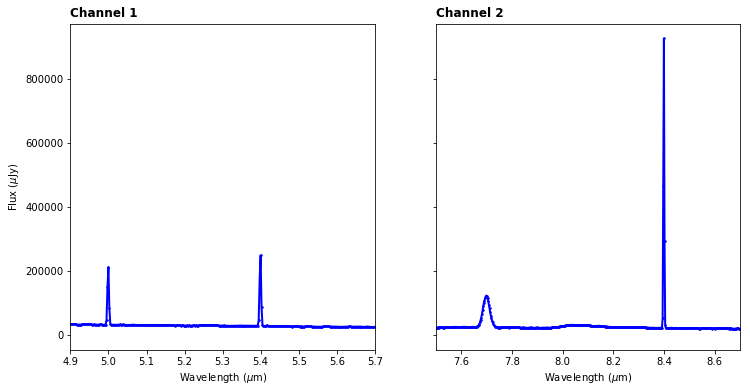

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# plot the spectrum in the channel 2 wavelength range
axs[0].plot(spec_dm.spec[0].spec_table['WAVELENGTH'], spec_dm.spec[0].spec_table['FLUX'], c='b', marker='.', markersize=3, linestyle='-', linewidth=2)
axs[0].set_ylabel(r'Flux ($\mu$Jy)')
axs[0].set_xlabel(r'Wavelength ($\mu$m)')
axs[0].set_xlim(4.9,5.7)
#axs[0].set_ylim(0,6000)
axs[0].annotate('Channel 1', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')


axs[1].plot(spec_dm.spec[0].spec_table['WAVELENGTH'], spec_dm.spec[0].spec_table['FLUX'], c='b', marker='.', markersize=3, linestyle='-', linewidth=2)
axs[1].set_xlabel(r'Wavelength ($\mu$m)')
axs[1].set_xlim(7.5,8.7)
axs[1].annotate('Channel 2', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')


plt.show()